In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')

In [3]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
bike_rentals.shape

(17379, 17)

In [5]:
bike_rentals.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [6]:
bike_rentals.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

We don't see any missing values.

Our target is `cnt`, which is the total number of bikes people rented in a given hour. Let's look at the distribution of its values.

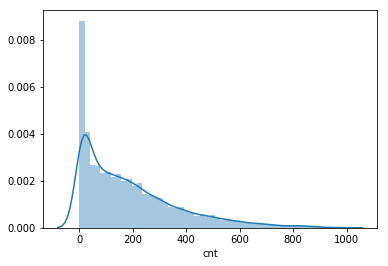

In [7]:
sns.distplot(bike_rentals['cnt'])

To make the `hr` feature more interpretable for the model, we'll split the hours into morning, afternoon, evening, and night.

In [8]:
def assign_label(row):
    if (row['hr'] > 6) & (row['hr'] <= 12):
        return 1
    elif (row['hr'] > 12) & (row['hr'] <= 18):
        return 2
    elif (row['hr'] > 18) & (row['hr'] <= 24):
        return 3
    elif (row['hr'] >= 0) & (row['hr'] <= 6):
        return 4

bike_rentals['time_label'] = bike_rentals.apply(assign_label, axis=1)

Let's look at the correlations each potential features have with our target.

In [9]:
bike_rentals.corr()['cnt'].sort_values()

time_label   -0.494422
hum          -0.322911
weathersit   -0.142426
holiday      -0.030927
weekday       0.026900
workingday    0.030284
windspeed     0.093234
mnth          0.120638
season        0.178056
yr            0.250495
instant       0.278379
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

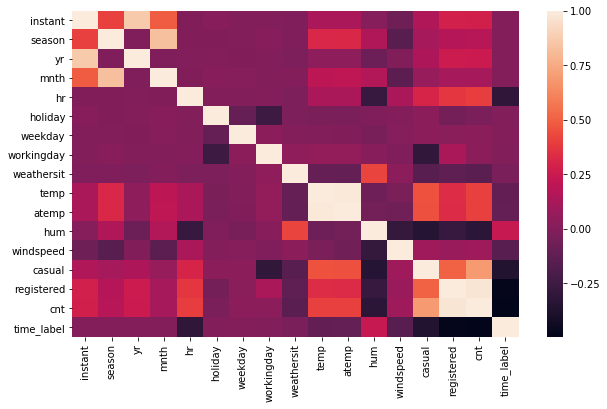

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(bike_rentals.corr())

Which columns to remove from the features list?

`cnt`, `casual`, `dteday`, `registered`, `instant`.

Some columns have high correlations with each other. We'll try to address this down below.

For our error metric, we'll use root mean square error. In the next step, we'll split the data into training and testing datasets.

In [11]:
from sklearn.model_selection import train_test_split
cols = bike_rentals.columns.difference(['cnt', 'casual', 'dteday', 'registered', 'instant'])
train_X, test_X, train_y, test_y = train_test_split(bike_rentals[cols], bike_rentals['cnt'], 
                                                    test_size = 0.3, random_state = 42)

# Linear Regression

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
predictions = lr.fit(train_X, train_y).predict(test_X)
error = np.sqrt(mean_squared_error(test_y, predictions))
print(error)

125.45282495398163


# Decision Tree

In [13]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
predictions = dt.fit(train_X, train_y).predict(test_X)
error = np.sqrt(mean_squared_error(test_y, predictions))
print(error)

60.57842233967931


There's a marked improvement from using a simple linear regression model to a decision tree regressor. Note that data assumptions of linear regression were not considered; RMSE score for linear regression might improve if the assumptions are tests and modified as needed. 

# Random Forests

In [14]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
%timeit predictions = rf.fit(train_X, train_y).predict(test_X)
predictions = rf.fit(train_X, train_y).predict(test_X)
error = np.sqrt(mean_squared_error(test_y, predictions))
print(error)

467 ms ± 3.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
44.8856603571475


There's a further reduction in RMSE score. Let's see which features were the most important in this analysis.

# Feature Importance

In [15]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = cols,
                                   columns=['importance']).sort_values('importance',      
                                                                        ascending=False)
feature_importances

,importance
time_label,0.314153
hr,0.292883
temp,0.121271
yr,0.080929
workingday,0.056983
hum,0.027182
atemp,0.022475
season,0.022259
weathersit,0.019853
mnth,0.016539


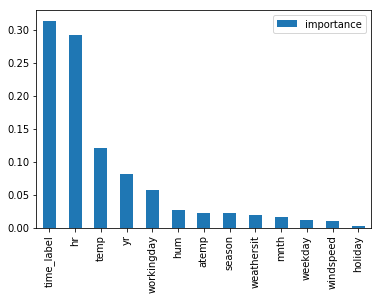

In [16]:
feature_importances.plot.bar()

# Cumulative importance

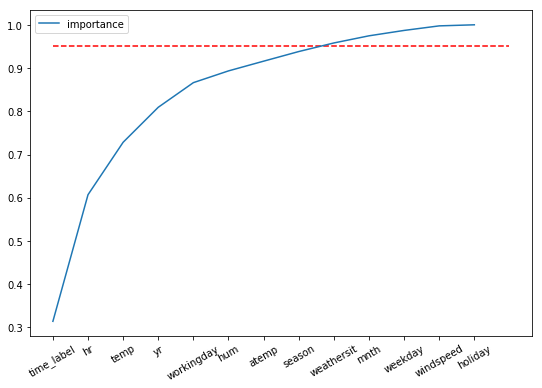

In [21]:
cumulative_importances = np.cumsum(feature_importances)
fig, ax = plt.subplots(figsize=(9,6))
cumulative_importances.plot(ax=ax, rot=30)
ax.set(xticks=range(len(cumulative_importances)),
       xticklabels=cumulative_importances.index)
plt.hlines(y=0.95, xmin=0, xmax=len(cumulative_importances),
           color='r', linestyles='dashed')

In [18]:
cumulative_importances

,importance
time_label,0.314153
hr,0.607036
temp,0.728306
yr,0.809236
workingday,0.866219
hum,0.893401
atemp,0.915876
season,0.938135
weathersit,0.957988
mnth,0.974527


Looks like the first half of features account for more than 90% of feature importance. We'll only keep the first half and re-run Random Forests.

In [22]:
new_cols = cumulative_importances[cumulative_importances['importance']<0.95].index

In [23]:
train_X, test_X, train_y, test_y = train_test_split(bike_rentals[new_cols], bike_rentals['cnt'], 
                                                    test_size = 0.3, random_state = 42)

rf = RandomForestRegressor()
%timeit predictions = rf.fit(train_X, train_y).predict(test_X)
predictions = rf.fit(train_X, train_y).predict(test_X)
error = np.sqrt(mean_squared_error(test_y, predictions))
print(error)

313 ms ± 8.77 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
53.71745499618855


# Outcomes

* There was an increase in improvement in speed performance - from 467 ms ± 3.55 ms to 313 ms ± 8.77 ms. 
* RMSE score suffered - from 44.9 to 53.7.